# FeatureTools tutorial

starting from: https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html

In [1]:
import featuretools as ft

data = ft.demo.load_mock_customer()

In [2]:
data

{'customers':    customer_id zip_code           join_date date_of_birth
 0            1    60091 2011-04-17 10:48:33    1994-07-18
 1            2    13244 2012-04-15 23:31:04    1986-08-18
 2            3    13244 2011-08-13 15:42:34    2003-11-21
 3            4    60091 2011-04-08 20:08:14    2006-08-15
 4            5    60091 2010-07-17 05:27:50    1984-07-28,
 'sessions':     session_id  customer_id   device       session_start
 0            1            2  desktop 2014-01-01 00:00:00
 1            2            5   mobile 2014-01-01 00:17:20
 2            3            4   mobile 2014-01-01 00:28:10
 3            4            1   mobile 2014-01-01 00:44:25
 4            5            4   mobile 2014-01-01 01:11:30
 5            6            1   tablet 2014-01-01 01:23:25
 6            7            3   tablet 2014-01-01 01:39:40
 7            8            4   tablet 2014-01-01 01:55:55
 8            9            1  desktop 2014-01-01 02:15:25
 9           10            2   tablet 20

Below we have a two tables of data (represented as Pandas DataFrames) related to customer transactions. The first is a merge of transactions, sessions, and customers so that the result looks like something you might see in a log file

In [3]:
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])

In [5]:
transactions_df

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18
1,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18
2,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18
3,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18
4,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18
...,...,...,...,...,...,...,...,...,...,...,...
495,112,35,2014-01-01 08:56:15,5,55.42,3,mobile,2014-01-01 08:44:20,13244,2011-08-13 15:42:34,2003-11-21
496,111,35,2014-01-01 08:57:20,3,34.87,3,mobile,2014-01-01 08:44:20,13244,2011-08-13 15:42:34,2003-11-21
497,276,35,2014-01-01 08:58:25,1,10.94,3,mobile,2014-01-01 08:44:20,13244,2011-08-13 15:42:34,2003-11-21
498,266,35,2014-01-01 08:59:30,5,19.86,3,mobile,2014-01-01 08:44:20,13244,2011-08-13 15:42:34,2003-11-21


In [6]:
products_df = data["products"]
products_df

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


## Creating an EntitySet

First, we initialize an EntitySet. If you’d like to give it name, you can optionally provide an id to the constructor.



In [7]:
es = ft.EntitySet(id="customer_data")
es

Entityset: customer_data
  Entities:
  Relationships:
    No relationships

## Adding entities

To get started, we load the transactions dataframe as an entity.

In [8]:
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time",
                              variable_types={"product_id": ft.variable_types.Categorical,
                                              "zip_code": ft.variable_types.ZIPCode})

In [9]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

In [10]:
es["transactions"]

Entity: transactions
  Variables:
    transaction_id (dtype: index)
    session_id (dtype: numeric)
    transaction_time (dtype: datetime_time_index)
    amount (dtype: numeric)
    customer_id (dtype: numeric)
    device (dtype: categorical)
    session_start (dtype: datetime)
    join_date (dtype: datetime)
    date_of_birth (dtype: datetime)
    product_id (dtype: categorical)
    zip_code (dtype: zip_code)
  Shape:
    (Rows: 500, Columns: 11)

In the call to entity_from_dataframe, we specified three important parameters

- The index parameter specifies the column that uniquely identifies rows in the dataframe

- The time_index parameter tells Featuretools when the data was created.

- The variable_types parameter indicates that “product_id” should be interpreted as a Categorical variable, even though it just an integer in the underlying data.

Now, we can do that same thing with our products dataframe

In [11]:
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")

In [13]:
es['products']

Entity: products
  Variables:
    product_id (dtype: index)
    brand (dtype: categorical)
  Shape:
    (Rows: 5, Columns: 2)

## Adding a Relationship

(parent_entity, parent_variable, child_entity, child_variable)

In [14]:
new_relationship = ft.Relationship(es["products"]["product_id"],
                                   es["transactions"]["product_id"])

es = es.add_relationship(new_relationship)
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.product_id -> products.product_id

## Creating entity from existing table

When working with raw data, it is common to have sufficient information to justify the creation of new entities. In order to create a new entity and relationship for sessions, we “normalize” the transaction entity.

In [15]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["device", "customer_id", "zip_code", "session_start", "join_date"])

In [16]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id

In [17]:
es["transactions"].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = id)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = id)>]

In [20]:
es["sessions"].variables

[<Variable: session_id (dtype = index)>,
 <Variable: device (dtype = categorical)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: zip_code (dtype = zip_code)>,
 <Variable: session_start (dtype: datetime_time_index, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>]

In [25]:
es["sessions"].df

,session_id,device,customer_id,zip_code,session_start,join_date
1,1,desktop,2,13244,2014-01-01 00:00:00,2012-04-15 23:31:04
2,2,mobile,5,60091,2014-01-01 00:17:20,2010-07-17 05:27:50
3,3,mobile,4,60091,2014-01-01 00:28:10,2011-04-08 20:08:14
4,4,mobile,1,60091,2014-01-01 00:44:25,2011-04-17 10:48:33
5,5,mobile,4,60091,2014-01-01 01:11:30,2011-04-08 20:08:14
6,6,tablet,1,60091,2014-01-01 01:23:25,2011-04-17 10:48:33
7,7,tablet,3,13244,2014-01-01 01:39:40,2011-08-13 15:42:34
8,8,tablet,4,60091,2014-01-01 01:55:55,2011-04-08 20:08:14
9,9,desktop,1,60091,2014-01-01 02:15:25,2011-04-17 10:48:33
10,10,tablet,2,13244,2014-01-01 02:31:40,2012-04-15 23:31:04


To finish preparing this dataset, create a “customers” entity using the same method call.

In [26]:
es = es.normalize_entity(base_entity_id="sessions",
                         new_entity_id="customers",
                         index="customer_id",
                         make_time_index="join_date",
                         additional_variables=["zip_code", "join_date"])

In [29]:
es['products']

Entity: products
  Variables:
    product_id (dtype: index)
    brand (dtype: categorical)
  Shape:
    (Rows: 5, Columns: 2)

In [28]:
feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity="products")

In [30]:
feature_defs

[<Feature: brand>,
 <Feature: COUNT(transactions)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: MIN(transactions.amount)>,
 <Feature: MODE(transactions.session_id)>,
 <Feature: NUM_UNIQUE(transactions.session_id)>,
 <Feature: SKEW(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: MODE(transactions.DAY(date_of_birth))>,
 <Feature: MODE(transactions.DAY(transaction_time))>,
 <Feature: MODE(transactions.MONTH(date_of_birth))>,
 <Feature: MODE(transactions.MONTH(transaction_time))>,
 <Feature: MODE(transactions.WEEKDAY(date_of_birth))>,
 <Feature: MODE(transactions.WEEKDAY(transaction_time))>,
 <Feature: MODE(transactions.YEAR(date_of_birth))>,
 <Feature: MODE(transactions.YEAR(transaction_time))>,
 <Feature: MODE(transactions.sessions.customer_id)>,
 <Feature: MODE(transactions.sessions.device)>,
 <Feature: NUM_UNIQUE(transactions.DAY(date_of_birth))>,
 <Feature: NUM_UNIQUE(transactions

In [31]:
feature_matrix

,brand,COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.session_id),NUM_UNIQUE(transactions.session_id),SKEW(transactions.amount),STD(transactions.amount),SUM(transactions.amount),...,NUM_UNIQUE(transactions.DAY(date_of_birth)),NUM_UNIQUE(transactions.DAY(transaction_time)),NUM_UNIQUE(transactions.MONTH(date_of_birth)),NUM_UNIQUE(transactions.MONTH(transaction_time)),NUM_UNIQUE(transactions.WEEKDAY(date_of_birth)),NUM_UNIQUE(transactions.WEEKDAY(transaction_time)),NUM_UNIQUE(transactions.YEAR(date_of_birth)),NUM_UNIQUE(transactions.YEAR(transaction_time)),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device)
product_id,,,,,,,,,,,,,,,,,,,,,
1,B,102,149.56,73.429314,6.84,3,34,0.125525,42.479989,7489.79,...,4,1,3,1,4,1,5,1,5,3
2,B,92,149.95,76.319891,5.73,28,34,0.151934,46.336308,7021.43,...,4,1,3,1,4,1,5,1,5,3
3,B,96,148.31,73.001250,5.89,1,35,0.223938,38.871405,7008.12,...,4,1,3,1,4,1,5,1,5,3
4,B,106,146.46,76.311038,5.81,29,34,-0.132077,42.492501,8088.97,...,4,1,3,1,4,1,5,1,5,3
5,A,104,149.02,76.264904,5.91,4,34,0.098248,42.131902,7931.55,...,4,1,3,1,4,1,5,1,5,3


# Deep Feature Synthesis

## Input Data

In [33]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

In [36]:
es['sessions']

Entity: sessions
  Variables:
    session_id (dtype: index)
    customer_id (dtype: id)
    device (dtype: categorical)
    session_start (dtype: datetime_time_index)
  Shape:
    (Rows: 35, Columns: 4)

## Running DFS

In [37]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=["count"],
                                      trans_primitives=["month"],
                                      max_depth=1)

In [38]:
feature_defs

[<Feature: zip_code>,
 <Feature: COUNT(sessions)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: MONTH(join_date)>]

In [39]:
feature_matrix

,zip_code,COUNT(sessions),MONTH(date_of_birth),MONTH(join_date)
customer_id,,,,
5,60091,6,7,7
4,60091,8,8,4
1,60091,8,7,4
3,13244,6,11,8
2,13244,7,8,4


## Creating “Deep Features”

In [40]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=["mean", "sum", "mode"],
                                      trans_primitives=["month", "hour"],
                                      max_depth=2)

In [41]:
feature_defs

[<Feature: zip_code>,
 <Feature: MODE(sessions.device)>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: MODE(transactions.product_id)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: HOUR(date_of_birth)>,
 <Feature: HOUR(join_date)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: MONTH(join_date)>,
 <Feature: MEAN(sessions.MEAN(transactions.amount))>,
 <Feature: MEAN(sessions.SUM(transactions.amount))>,
 <Feature: MODE(sessions.HOUR(session_start))>,
 <Feature: MODE(sessions.MODE(transactions.product_id))>,
 <Feature: MODE(sessions.MONTH(session_start))>,
 <Feature: SUM(sessions.MEAN(transactions.amount))>,
 <Feature: MODE(transactions.sessions.customer_id)>,
 <Feature: MODE(transactions.sessions.device)>]

In [42]:
feature_matrix

,zip_code,MODE(sessions.device),MEAN(transactions.amount),MODE(transactions.product_id),SUM(transactions.amount),HOUR(date_of_birth),HOUR(join_date),MONTH(date_of_birth),MONTH(join_date),MEAN(sessions.MEAN(transactions.amount)),MEAN(sessions.SUM(transactions.amount)),MODE(sessions.HOUR(session_start)),MODE(sessions.MODE(transactions.product_id)),MODE(sessions.MONTH(session_start)),SUM(sessions.MEAN(transactions.amount)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device)
customer_id,,,,,,,,,,,,,,,,,
5,60091,mobile,80.375443,5,6349.66,0,5,7,7,78.705187,1058.276667,0,3,1,472.231119,5,mobile
4,60091,mobile,80.070459,2,8727.68,0,20,8,4,81.207189,1090.960000,1,1,1,649.657515,4,mobile
1,60091,mobile,71.631905,4,9025.62,0,10,7,4,72.774140,1128.202500,6,4,1,582.193117,1,mobile
3,13244,desktop,67.060430,1,6236.62,0,15,11,8,67.539577,1039.436667,5,1,1,405.237462,3,desktop
2,13244,desktop,77.422366,4,7200.28,0,23,8,4,78.415122,1028.611429,3,3,1,548.905851,2,desktop


In [43]:
feature_matrix[['MEAN(sessions.SUM(transactions.amount))']]

,MEAN(sessions.SUM(transactions.amount))
customer_id,
5,1058.276667
4,1090.960000
1,1128.202500
3,1039.436667
2,1028.611429


## Changing Target Entity

In [44]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="sessions",
                                      agg_primitives=["mean", "sum", "mode"],
                                      trans_primitives=["month", "hour"],
                                      max_depth=2)

In [45]:
feature_defs

[<Feature: customer_id>,
 <Feature: device>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: MODE(transactions.product_id)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: HOUR(session_start)>,
 <Feature: MONTH(session_start)>,
 <Feature: customers.zip_code>,
 <Feature: MODE(transactions.HOUR(transaction_time))>,
 <Feature: MODE(transactions.MONTH(transaction_time))>,
 <Feature: MODE(transactions.products.brand)>,
 <Feature: customers.MODE(sessions.device)>,
 <Feature: customers.MEAN(transactions.amount)>,
 <Feature: customers.MODE(transactions.product_id)>,
 <Feature: customers.SUM(transactions.amount)>,
 <Feature: customers.HOUR(date_of_birth)>,
 <Feature: customers.HOUR(join_date)>,
 <Feature: customers.MONTH(date_of_birth)>,
 <Feature: customers.MONTH(join_date)>]

In [46]:
feature_matrix

,customer_id,device,MEAN(transactions.amount),MODE(transactions.product_id),SUM(transactions.amount),HOUR(session_start),MONTH(session_start),customers.zip_code,MODE(transactions.HOUR(transaction_time)),MODE(transactions.MONTH(transaction_time)),MODE(transactions.products.brand),customers.MODE(sessions.device),customers.MEAN(transactions.amount),customers.MODE(transactions.product_id),customers.SUM(transactions.amount),customers.HOUR(date_of_birth),customers.HOUR(join_date),customers.MONTH(date_of_birth),customers.MONTH(join_date)
session_id,,,,,,,,,,,,,,,,,,,
1,2,desktop,76.813125,3,1229.01,0,1,13244,0,1,B,desktop,77.422366,4,7200.28,0,23,8,4
2,5,mobile,74.696000,5,746.96,0,1,60091,0,1,A,mobile,80.375443,5,6349.66,0,5,7,7
3,4,mobile,88.600000,1,1329.00,0,1,60091,0,1,B,mobile,80.070459,2,8727.68,0,20,8,4
4,1,mobile,64.557200,5,1613.93,0,1,60091,0,1,B,mobile,71.631905,4,9025.62,0,10,7,4
5,4,mobile,70.638182,5,777.02,1,1,60091,1,1,B,mobile,80.070459,2,8727.68,0,20,8,4
6,1,tablet,84.440000,4,1266.60,1,1,60091,1,1,B,mobile,71.631905,4,9025.62,0,10,7,4
7,3,tablet,62.791333,1,941.87,1,1,13244,1,1,B,desktop,67.060430,1,6236.62,0,15,11,8
8,4,tablet,75.081111,1,1351.46,1,1,60091,2,1,B,mobile,80.070459,2,8727.68,0,20,8,4
9,1,desktop,70.135333,1,1052.03,2,1,60091,2,1,B,mobile,71.631905,4,9025.62,0,10,7,4


In [47]:
feature_matrix[['customers.MEAN(transactions.amount)']]

,customers.MEAN(transactions.amount)
session_id,
1,77.422366
2,80.375443
3,80.070459
4,71.631905
5,80.070459
6,71.631905
7,67.060430
8,80.070459
9,71.631905


In [50]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="transactions",
                                      agg_primitives=["mean", "sum", "mode"],
                                      trans_primitives=["month", "hour"],
                                      max_depth=2)

In [51]:
feature_defs

[<Feature: session_id>,
 <Feature: amount>,
 <Feature: product_id>,
 <Feature: HOUR(transaction_time)>,
 <Feature: MONTH(transaction_time)>,
 <Feature: products.brand>,
 <Feature: sessions.customer_id>,
 <Feature: sessions.device>,
 <Feature: products.MEAN(transactions.amount)>,
 <Feature: products.MODE(transactions.session_id)>,
 <Feature: products.SUM(transactions.amount)>,
 <Feature: sessions.MEAN(transactions.amount)>,
 <Feature: sessions.MODE(transactions.product_id)>,
 <Feature: sessions.SUM(transactions.amount)>,
 <Feature: sessions.HOUR(session_start)>,
 <Feature: sessions.MONTH(session_start)>,
 <Feature: sessions.customers.zip_code>]

In [52]:
feature_matrix

,session_id,amount,product_id,HOUR(transaction_time),MONTH(transaction_time),products.brand,sessions.customer_id,sessions.device,products.MEAN(transactions.amount),products.MODE(transactions.session_id),products.SUM(transactions.amount),sessions.MEAN(transactions.amount),sessions.MODE(transactions.product_id),sessions.SUM(transactions.amount),sessions.HOUR(session_start),sessions.MONTH(session_start),sessions.customers.zip_code
transaction_id,,,,,,,,,,,,,,,,,
298,1,127.64,5,0,1,A,2,desktop,76.264904,4,7931.55,76.813125,3,1229.01,0,1,13244
2,1,109.48,2,0,1,B,2,desktop,76.319891,28,7021.43,76.813125,3,1229.01,0,1,13244
308,1,95.06,3,0,1,B,2,desktop,73.001250,1,7008.12,76.813125,3,1229.01,0,1,13244
116,1,78.92,4,0,1,B,2,desktop,76.311038,29,8088.97,76.813125,3,1229.01,0,1,13244
371,1,31.54,3,0,1,B,2,desktop,73.001250,1,7008.12,76.813125,3,1229.01,0,1,13244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,35,55.42,5,8,1,A,3,mobile,76.264904,4,7931.55,60.041875,5,960.67,8,1,13244
111,35,34.87,3,8,1,B,3,mobile,73.001250,1,7008.12,60.041875,5,960.67,8,1,13244
276,35,10.94,1,8,1,B,3,mobile,73.429314,3,7489.79,60.041875,5,960.67,8,1,13244


# Feature primitives

## Why primitives?

In [61]:
import featuretools as ft

es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=["mean"],
                                      trans_primitives=["time_since_previous"]
)

feature_defs

[<Feature: zip_code>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: TIME_SINCE_PREVIOUS(join_date)>,
 <Feature: MEAN(sessions.MEAN(transactions.amount))>,
 <Feature: MEAN(sessions.TIME_SINCE_PREVIOUS(session_start))>]

In [62]:
feature_matrix

,zip_code,MEAN(transactions.amount),TIME_SINCE_PREVIOUS(join_date),MEAN(sessions.MEAN(transactions.amount)),MEAN(sessions.TIME_SINCE_PREVIOUS(session_start))
customer_id,,,,,
5,60091,80.375443,NaN,78.705187,1007.500000
4,60091,80.070459,22948824.0,81.207189,999.375000
1,60091,71.631905,744019.0,72.774140,966.875000
3,13244,67.060430,10212841.0,67.539577,888.333333
2,13244,77.422366,21282510.0,78.415122,725.833333


# Variable Types

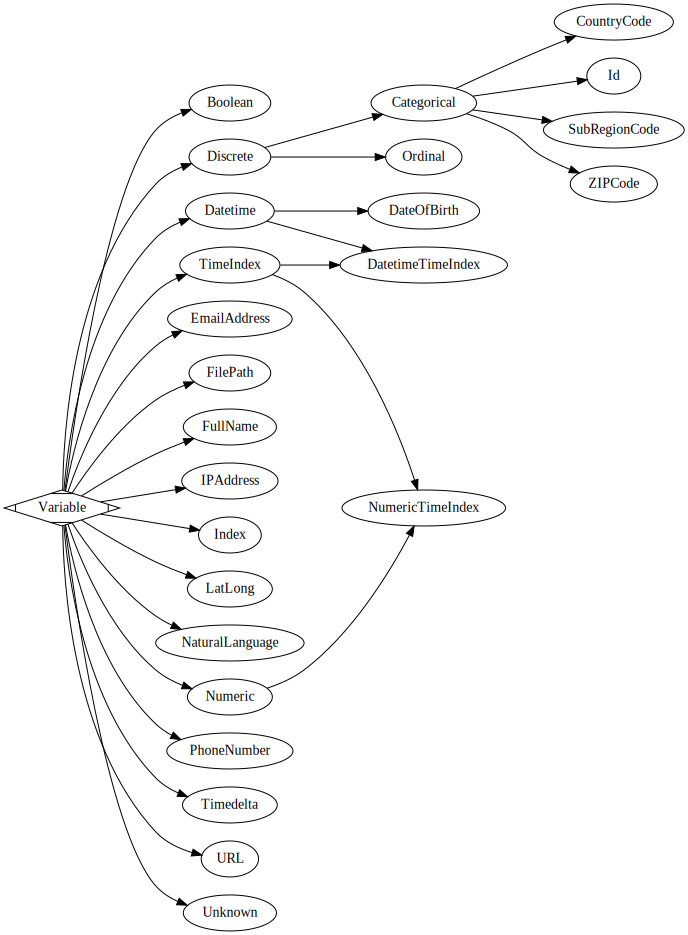

In [63]:
from featuretools.variable_types import graph_variable_types
graph_variable_types()

In [64]:
import pandas as pd

data = pd.DataFrame()
data['latitude'] = [51.52, 9.93, 37.38]
data['longitude'] = [-0.17, 76.25, -122.08]
data['latlong'] = data[['latitude', 'longitude']].apply(tuple, axis=1)
data['latlong']

0      (51.52, -0.17)
1       (9.93, 76.25)
2    (37.38, -122.08)
Name: latlong, dtype: object

# Handling Time

## What is the Time Index?

In [65]:
import featuretools as ft

es = ft.demo.load_mock_customer(return_entityset=True, random_seed=0)
es['transactions'].df.head()

,transaction_id,session_id,transaction_time,amount,product_id
298,298,1,2014-01-01 00:00:00,127.64,5
2,2,1,2014-01-01 00:01:05,109.48,2
308,308,1,2014-01-01 00:02:10,95.06,3
116,116,1,2014-01-01 00:03:15,78.92,4
371,371,1,2014-01-01 00:04:20,31.54,3


In [66]:
es['customers'].df

,customer_id,join_date,date_of_birth,zip_code
5,5,2010-07-17 05:27:50,1984-07-28,60091
4,4,2011-04-08 20:08:14,2006-08-15,60091
1,1,2011-04-17 10:48:33,1994-07-18,60091
3,3,2011-08-13 15:42:34,2003-11-21,13244
2,2,2012-04-15 23:31:04,1986-08-18,13244


## Cutoff Time?

In [67]:
fm, features = ft.dfs(entityset=es,
                      target_entity='customers',
                      cutoff_time=pd.Timestamp("2014-1-1 04:00"),
                      instance_ids=[1,2,3],
                      cutoff_time_in_index=True)

In [68]:
fm

,,zip_code,COUNT(sessions),MODE(sessions.device),NUM_UNIQUE(sessions.device),COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.product_id),NUM_UNIQUE(transactions.product_id),...,SUM(sessions.MAX(transactions.amount)),SUM(sessions.MEAN(transactions.amount)),SUM(sessions.MIN(transactions.amount)),SUM(sessions.NUM_UNIQUE(transactions.product_id)),SUM(sessions.SKEW(transactions.amount)),SUM(sessions.STD(transactions.amount)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device)
customer_id,time,,,,,,,,,,,,,,,,,,,,,
1,2014-01-01 04:00:00,60091,4,tablet,3,67,139.23,74.002836,5.81,4,5,...,540.04,304.601700,27.62,20,-0.505043,169.572874,1,tablet,1,3
2,2014-01-01 04:00:00,13244,4,desktop,2,49,146.81,84.700000,12.07,4,5,...,569.29,340.791792,105.24,20,0.045171,157.262738,2,desktop,1,2
3,2014-01-01 04:00:00,13244,1,tablet,1,15,146.31,62.791333,8.19,1,5,...,146.31,62.791333,8.19,5,0.618455,47.264797,3,tablet,1,1


In [69]:
cutoff_times = pd.DataFrame()

cutoff_times['customer_id'] = [1, 2, 3, 1]

cutoff_times['time'] = pd.to_datetime(['2014-1-1 04:00',
                                       '2014-1-1 05:00',                              
                                       '2014-1-1 06:00',
                                       '2014-1-1 08:00'])

In [71]:
cutoff_times['label'] = [True, True, False, True]
cutoff_times

,customer_id,time,label
0,1,2014-01-01 04:00:00,True
1,2,2014-01-01 05:00:00,True
2,3,2014-01-01 06:00:00,False
3,1,2014-01-01 08:00:00,True


In [72]:
fm, features = ft.dfs(entityset=es,
                       target_entity='customers',
                       cutoff_time=cutoff_times,
                       cutoff_time_in_index=True)

fm

,,zip_code,COUNT(sessions),MODE(sessions.device),NUM_UNIQUE(sessions.device),COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.product_id),NUM_UNIQUE(transactions.product_id),...,SUM(sessions.MEAN(transactions.amount)),SUM(sessions.MIN(transactions.amount)),SUM(sessions.NUM_UNIQUE(transactions.product_id)),SUM(sessions.SKEW(transactions.amount)),SUM(sessions.STD(transactions.amount)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device),label
customer_id,time,,,,,,,,,,,,,,,,,,,,,
1,2014-01-01 04:00:00,60091,4,tablet,3,67,139.23,74.002836,5.81,4,5,...,304.601700,27.62,20,-0.505043,169.572874,1,tablet,1,3,True
2,2014-01-01 05:00:00,13244,5,desktop,2,62,146.81,83.149355,12.07,4,5,...,418.096407,127.06,25,-0.269747,190.987775,2,desktop,1,2,True
3,2014-01-01 06:00:00,13244,4,desktop,2,44,146.31,65.174773,6.65,1,5,...,290.968018,126.66,16,0.860577,119.136697,3,desktop,1,2,False
1,2014-01-01 08:00:00,60091,8,mobile,3,126,139.43,71.631905,5.81,4,5,...,582.193117,78.59,40,-0.476122,312.745952,1,mobile,1,3,True


## Training Window

In [73]:
window_fm, window_features = ft.dfs(entityset=es,
                                    target_entity="customers",
                                    cutoff_time=cutoff_times,
                                    cutoff_time_in_index=True,
                                    training_window="2 hour")

In [74]:
window_fm

,,zip_code,COUNT(sessions),MODE(sessions.device),NUM_UNIQUE(sessions.device),COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.product_id),NUM_UNIQUE(transactions.product_id),...,SUM(sessions.MEAN(transactions.amount)),SUM(sessions.MIN(transactions.amount)),SUM(sessions.NUM_UNIQUE(transactions.product_id)),SUM(sessions.SKEW(transactions.amount)),SUM(sessions.STD(transactions.amount)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device),label
customer_id,time,,,,,,,,,,,,,,,,,,,,,
1,2014-01-01 04:00:00,60091,2,desktop,2,27,139.09,76.950370,5.81,4,5,...,155.604500,12.59,10,-0.604638,86.730914,1,desktop,1,2,True
2,2014-01-01 05:00:00,13244,3,desktop,2,31,146.81,84.051935,12.07,4,5,...,253.240615,90.35,15,-0.110009,109.500185,2,desktop,1,2,True
3,2014-01-01 06:00:00,13244,3,desktop,1,29,128.26,66.407586,6.65,1,5,...,228.176684,118.47,11,0.242122,71.871900,3,desktop,1,1,False
1,2014-01-01 08:00:00,60091,3,mobile,2,47,139.43,66.471277,5.91,4,5,...,198.984750,24.61,15,-0.003438,107.128899,1,mobile,1,2,True


## Secondary Time Index

In [95]:
es_flight = ft.demo.load_flight(nrows=100)

In [96]:
es_flight

Entityset: Flight Data
  Entities:
    trip_logs [Rows: 100, Columns: 21]
    flights [Rows: 13, Columns: 9]
    airlines [Rows: 1, Columns: 1]
    airports [Rows: 6, Columns: 3]
  Relationships:
    trip_logs.flight_id -> flights.flight_id
    flights.carrier -> airlines.carrier
    flights.dest -> airports.dest

In [79]:
es_flight['trip_logs'].df

,trip_log_id,flight_id,date_scheduled,scheduled_dep_time,scheduled_arr_time,dep_time,arr_time,dep_delay,taxi_out,taxi_in,arr_delay,scheduled_elapsed_time,air_time,distance,carrier_delay,weather_delay,national_airspace_delay,security_delay,late_aircraft_delay,canceled,diverted
30,30,AA-494:RSW->CLT,2016-09-03,2017-01-01 13:14:00,2017-01-01 15:05:00,2017-01-01 13:03:00,2017-01-01 14:53:00,-11.0,12.0,10.0,-12.0,6660000000000,88.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,38,AA-495:ATL->PHX,2016-09-03,2017-01-01 11:30:00,2017-01-01 15:40:00,2017-01-01 11:24:00,2017-01-01 15:41:00,-6.0,28.0,5.0,1.0,15000000000000,224.0,1587.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,46,AA-495:CLT->ATL,2016-09-03,2017-01-01 09:25:00,2017-01-01 10:42:00,2017-01-01 09:23:00,2017-01-01 10:39:00,-2.0,18.0,8.0,-3.0,4620000000000,50.0,226.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,82,AA-495:TPA->CLT,2016-09-03,2017-01-01 06:38:00,2017-01-01 08:19:00,2017-01-01 06:33:00,2017-01-01 08:13:00,-5.0,12.0,6.0,-6.0,6060000000000,82.0,507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,92,AA-496:PIT->DFW,2016-09-03,2017-01-01 07:00:00,2017-01-01 10:23:00,2017-01-01 06:54:00,2017-01-01 10:28:00,-6.0,28.0,15.0,5.0,12180000000000,171.0,1067.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,AA-495:PIT->PHX,2016-10-02,2017-01-30 10:55:00,2017-01-30 15:41:00,2017-01-30 11:52:00,2017-01-30 16:00:00,57.0,9.0,3.0,19.0,17160000000000,236.0,1814.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
14,14,AA-494:CLT->PHX,2016-10-03,2017-01-31 16:19:00,2017-01-31 20:56:00,2017-01-31 16:15:00,2017-01-31 20:36:00,-4.0,18.0,7.0,-20.0,16620000000000,236.0,1773.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,81,AA-495:PIT->PHX,2016-10-03,2017-01-31 10:55:00,2017-01-31 15:41:00,2017-01-31 10:55:00,2017-01-31 15:22:00,0.0,10.0,4.0,-19.0,17160000000000,253.0,1814.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,87,AA-496:PHL->PHX,2016-10-03,2017-01-31 10:35:00,2017-01-31 16:01:00,2017-01-31 10:31:00,2017-01-31 15:58:00,-4.0,13.0,3.0,-3.0,19560000000000,311.0,2075.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
es = ft.EntitySet('Flight Data')

arr_time_columns = ['arr_delay', 'dep_delay', 'carrier_delay', 'weather_delay',
                    'national_airspace_delay', 'security_delay',
                    'late_aircraft_delay', 'canceled', 'diverted',
                    'taxi_in', 'taxi_out', 'air_time', 'dep_time']

es.entity_from_dataframe('trip_logs',
                         data,
                         index='trip_log_id',
                         make_index=True,
                         time_index='date_scheduled',
                         secondary_time_index={'arr_time': arr_time_columns})

#es = es.entity_from_dataframe(entity_id="transactions",
                              #dataframe=transactions_df,
                              #index="transaction_id",
                              #time_index="transaction_time",
                              #variable_types={"product_id": ft.variable_types.Categorical,
                                              #"zip_code": ft.variable_types.ZIPCode})

LookupError: Time index not found in dataframe